<a href="https://colab.research.google.com/github/wintwah243/demo-for-GreenAI/blob/main/AI_Presentation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Community Involvement Guidance Using RAG-based Engine


In [2]:
!pip install -q pandas openpyxl sentence-transformers langchain faiss-cpu openai

In [3]:
from google.colab import files
uploaded = files.upload()

Saving final_dataset.xlsx to final_dataset.xlsx


In [4]:
import pandas as pd

df = pd.read_excel("final_dataset.xlsx")
df.head()

,Interest_Area,Level,GuideLine_Text
0,recycling,Beginner,Begin by learning how to sort common household...
1,teaching,Beginner,Start by choosing a topic you feel confident a...
2,water conservation,Beginner,Reuse water from washing vegetables for wateri...
3,tree planting,Beginner,Start by choosing a suitable location in your ...
4,saving electricity,Beginner,Start by organizing a group talk to explain wh...


In [5]:
df = (
    df
    .rename(columns={
        'Interest_Area': 'topic',
        'Level': 'user_level',
        'GuideLine_Text': 'guideline_text'
    })
    .dropna(subset=['topic', 'user_level', 'guideline_text'])
)

# Normalise text for filtering
df['topic'] = df['topic'].str.strip().str.lower()
df['user_level'] = df['user_level'].str.strip().str.lower()

print("Unique topics:", df['topic'].unique())
print("Rows:", len(df))


Unique topics: ['recycling' 'teaching' 'water conservation' 'tree planting'
 'saving electricity' 'cleaning public space' 'plastic free'
 'mental healing' 'helping elderly people' 'supporting local farmers'
 'community storytelling' 'leadership' 'public speaking' 'donation'
 'environment' 'clean water access' 'volunteering' 'child nutrition'
 'digital skills' 'disaster prep' 'book sharing' 'fundraising'
 'first aid training' 'road safety campaign' 'anti-bullying'
 'language tutoring' 'climate change' 'peaceful conflict resolution'
 'no poverty' 'gardening' 'gender equality' 'energy saving'
 'disability awareness' 'ocean pollution' 'basic health check']
Rows: 70


In [6]:
!pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00


In [7]:
!pip install -U langchain-huggingface
!pip install faiss-cpu

from sentence_transformers import SentenceTransformer
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

embedder = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

vector_db = FAISS.from_texts(
    texts      = df['guideline_text'].tolist(),
    embedding  = embedder,
    metadatas  = df[['topic', 'user_level']].to_dict(orient='records')
)

vector_db.save_local('/content/guide_index')
print("Index built & saved")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Index built & saved


In [8]:
def get_retriever(topic: str, level: str, k: int = 4):
    return vector_db.as_retriever(
        search_kwargs={
            "k": k,
            "filter": {
                "topic": topic.lower(),
                "user_level": level.lower()
            }
        }
    )

In [9]:
from langchain.llms import HuggingFacePipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline

model_name = "google/flan-t5-large"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
hf_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Create the pipeline
pipe = pipeline("text2text-generation",
                model=hf_model,
                tokenizer=tokenizer,
                max_new_tokens=256,
                do_sample=False)

# Wrap with LangChain
llm = HuggingFacePipeline(pipeline=pipe)


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cpu
/tmp/ipython-input-9-1111624827.py:18: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipe)


In [10]:
from langchain.prompts import PromptTemplate
from transformers import AutoTokenizer
from textwrap import dedent

# Load tokenizer once
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")

# prompt
prompt_tmpl = PromptTemplate(
    input_variables=["context", "topic", "level", "extra"],
    template=dedent("""
        Using the following information, write up to 6 simple, numbered steps for a {level} learner interested in {topic}.

        Context:
        {context}

        Extra focus: {extra}

        Steps:
    """).strip()
)

def truncate_to_fit(prompt_template: str, context: str, topic: str, level: str, extra: str, max_tokens: int = 512) -> str:
    dummy_context = ""
    base_prompt = prompt_template.format(context=dummy_context, topic=topic, level=level, extra=extra)
    base_token_count = len(tokenizer(base_prompt)["input_ids"])
    available = max_tokens - base_token_count
    ctx_tokens = tokenizer(context, truncation=True, max_length=available)
    return tokenizer.decode(ctx_tokens["input_ids"], skip_special_tokens=True)

def generate_guidelines(topic: str, level: str, extra: str = "") -> str:
    retriever = get_retriever(topic, level, k=4)
    docs = retriever.invoke(f"Topic: {topic}; Level: {level}; Extra: {extra}")
    raw_context = "\n".join(d.page_content for d in docs) if docs else "No matches found."
    context = truncate_to_fit(prompt_tmpl.template, raw_context, topic, level, extra)

    prompt = prompt_tmpl.format(context=context, topic=topic, level=level, extra=extra)

    # Debugging
    #print("\n--- Prompt sent to LLM ---")
    #print(prompt)
    #print("-------------------------\n")

    response = llm.invoke(prompt)
    return response.strip()

# testing
test_topic = "saving electricity"
test_level = "experienced"
test_extra = "focus on campaign"

print("🔍 Generated Guidelines:\n")
print(generate_guidelines(test_topic, test_level, test_extra))

🔍 Generated Guidelines:

Conduct an energy audit in your community to identify major areas of electricity consumption and wastage. Organize workshops to educate residents on advanced energy-saving technologies such as LED lighting, smart meters, and energy-efficient appliances. Facilitate group initiatives to retrofit homes and public buildings with energy-efficient systems.


In [11]:
print(df.dtypes)


topic             object
user_level        object
guideline_text    object
dtype: object


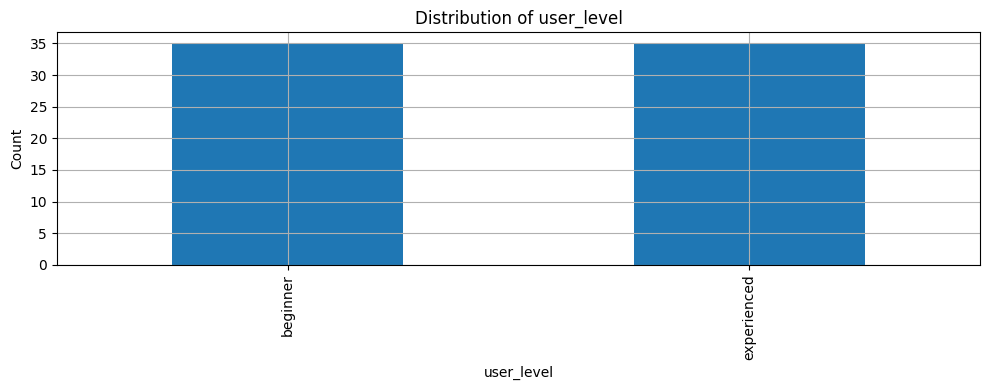

In [12]:
import matplotlib.pyplot as plt

col = 'user_level'

df[col].value_counts().plot(kind='bar', figsize=(10, 4))
plt.title(f"Distribution of {col}")
plt.xlabel(col)
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
!pip install --quiet scikit-learn sentence-transformers faiss-cpu

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10_000,
    ngram_range=(1,2),
    stop_words='english'
)
X_tfidf = tfidf.fit_transform(df['guideline_text'])

print("TF‑IDF matrix shape:", X_tfidf.shape)   # (rows, vocab_size)
# Now X_tfidf can feed classic ML models (log‑reg, SVM, etc.)

from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

model = SentenceTransformer("all-MiniLM-L6-v2")  # small & fast
embeddings = model.encode(df['guideline_text'].tolist(), show_progress_bar=True)

print("Embeddings shape:", embeddings.shape)     # (rows, 384)

# Build a FAISS index for fast similarity search
d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(np.array(embeddings).astype("float32"))

# query
query = "steps to save electricity at home"
q_emb = model.encode([query])
D, I = index.search(np.array(q_emb).astype("float32"), k=5)
print("\nTop‑5 closest guideline rows:")
print(df.iloc[I[0]][['topic', 'user_level', 'guideline_text']])

TF‑IDF matrix shape: (70, 2902)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Embeddings shape: (70, 384)

Top‑5 closest guideline rows:
                 topic   user_level  \
4   saving electricity     beginner   
11  saving electricity  experienced   
59       energy saving     beginner   
66       energy saving  experienced   
47      climate change     beginner   

                                       guideline_text  
4   Start by organizing a group talk to explain wh...  
11  Start by conducting an energy audit in your co...  
59  Start by learning how everyday actions affect ...  
66  Begin by conducting an energy audit to underst...  
47  Start by learning about climate change and how...  


In [16]:
!pip install --quiet scikit-learn

# 📚 Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd

text_col = 'guideline_text'
label_col = 'user_level'

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(df[text_col])
y = df[label_col]

# ✂️ Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

#  Predict and evaluate
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

📊 Classification Report:
              precision    recall  f1-score   support

    beginner       0.88      1.00      0.93         7
 experienced       1.00      0.86      0.92         7

    accuracy                           0.93        14
   macro avg       0.94      0.93      0.93        14
weighted avg       0.94      0.93      0.93        14



📄 Classification Report:
              precision    recall  f1-score   support

    beginner       0.88      1.00      0.93         7
 experienced       1.00      0.86      0.92         7

    accuracy                           0.93        14
   macro avg       0.94      0.93      0.93        14
weighted avg       0.94      0.93      0.93        14

Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1-score: 0.93


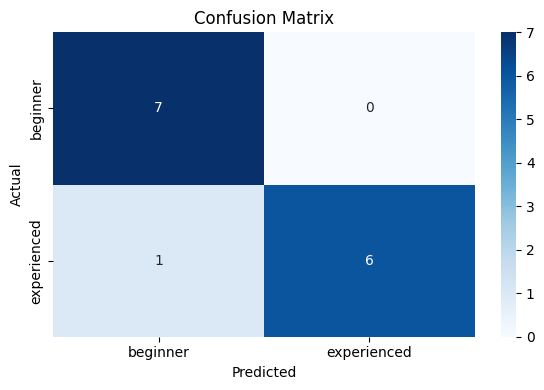

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision, Recall, F1 (macro averages for multi-class)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

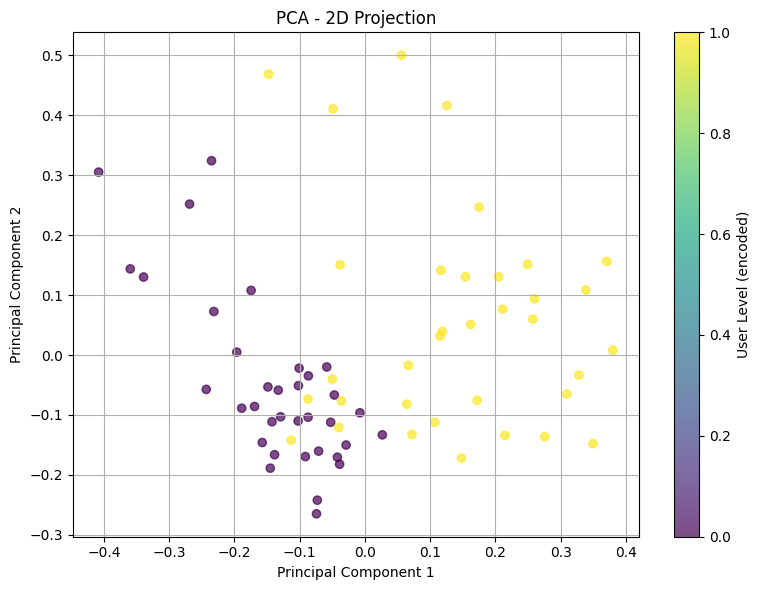

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Encode string labels to integers (e.g., beginner → 0, experienced → 1)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plot the PCA result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - 2D Projection')
plt.colorbar(scatter, label='User Level (encoded)')
plt.grid(True)
plt.tight_layout()
plt.show()

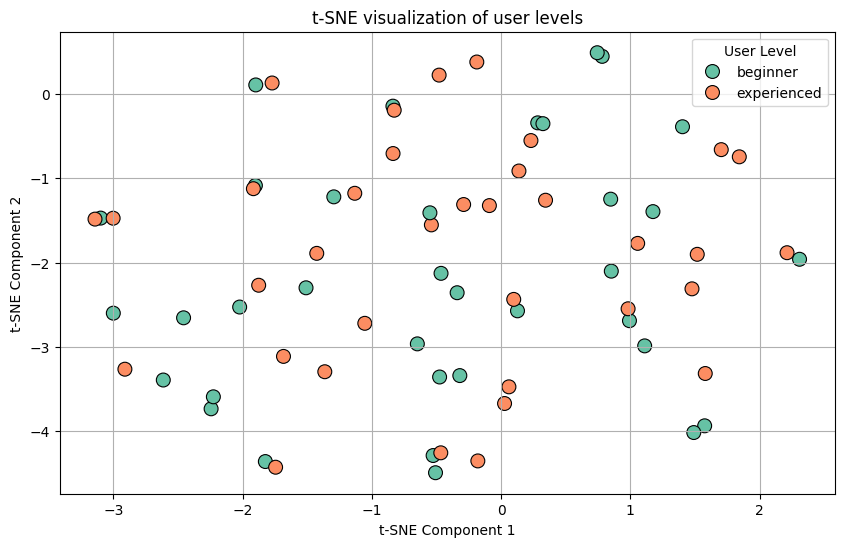

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

X_dense = X.toarray() if hasattr(X, "toarray") else X

tsne = TSNE(n_components=2, perplexity=40, random_state=42)
X_tsne = tsne.fit_transform(X_dense)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set2', s=100, edgecolor='k')
plt.title("t-SNE visualization of user levels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="User Level")
plt.grid(True)
plt.show()

Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1 Score: 0.93

Classification Report:
              precision    recall  f1-score   support

    beginner       0.88      1.00      0.93         7
 experienced       1.00      0.86      0.92         7

    accuracy                           0.93        14
   macro avg       0.94      0.93      0.93        14
weighted avg       0.94      0.93      0.93        14



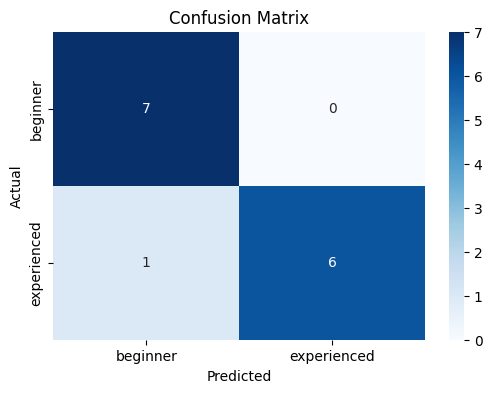

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()